<a href="https://colab.research.google.com/github/abuwildanm/food-recognition/blob/master/Food_Recognition_ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Indonesian Food Recognition

## Check GPU device

In [1]:
!nvidia-smi

Fri May 21 21:51:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Cloning and Building Darknet

The following cells will clone darknet from AlexeyAB's famous repository, adjust the Makefile to enable OPENCV and GPU for darknet and then build darknet.

In [2]:
# Clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15050, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 15050 (delta 16), reused 34 (delta 14), pack-reused 15002
Receiving objects: 100% (15050/15050), 13.48 MiB | 23.16 MiB/s, done.
Resolving deltas: 100% (10215/10215), done.


In [3]:
# Change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


In [4]:
# Verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [5]:
# Make darknet (build)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:935:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1136:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

## Download pretrained YOLOv3 weights

YOLOv3 has been trained already on the coco dataset which has 80 classes that it can predict. We will grab these pretrained weights so that we can run YOLOv3 on these pretrained classes and get detections.

In [6]:
%cd /content/

/content


In [7]:
# Download yolov3 pretrained weights
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://pjreddie.com/media/files/yolov3-tiny.weights
# Make yolov3 directory
!mkdir -p ./models/yolov3/
# Copy yolov3 weights to yolov3 directory
!cp {yolov3.weights,yolov3-tiny.weights} ./models/yolov3/
# Create symbolic link for yolov3 directory
!ln -s /content/models/yolov3 /yolov3

--2021-05-21 21:52:44--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  43.9MB/s    in 5.8s    

2021-05-21 21:52:51 (40.8 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2021-05-21 21:52:51--  https://pjreddie.com/media/files/yolov3-tiny.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35434956 (34M) [application/octet-stream]
Saving to: ‘yolov3-tiny.weights’

yolov3-tiny.weights 100%[===================>]  33.79M  29.3MB/s    in 1.2s    

2021-05-21 21:52:52 (29.3 MB/s) - ‘yolov3-tiny.weights’ saved [35434956/35434956]



In [8]:
# Define helper functions
def imshow(path):
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    image = plt.imread(path)
    
    fig = plt.gcf()
    fig.set_size_inches(18, 10)
    plt.axis("off")
    plt.imshow(image)
    plt.show()

# Use this to upload files
def upload():
    from google.colab import files
    uploaded = files.upload() 
    for name, data in uploaded.items():
        with open(name, 'wb') as f:
            f.write(data)
            print ('saved file', name)

# Use this to download a file  
def download(path):
    from google.colab import files
    files.download(path)

## Run Object Detection with Darknet and YOLOv3

Darknet is now built and ready to run detections using YOLOv3 in the cloud! We can find out which sorts of classes the pretrained YOLOv3 weights can detect by clicking here. [COCO CLASSES](http://cocodataset.org/#explore)

The object detector can be run using the following command
```bash
!./darknet detect <path to config> <path to weights> <path to image>
```
Darknet comes with a few images already installed in the darknet/data/ folder.

**Note:** After running detections OpenCV can't open the image instantly in the cloud so we must run: 
```bash
imshow('predictions.jpg')
```
This will output the image with the detections shown. The most recent detections are always saved to 'predictions.jpg'

In [9]:
%cd darknet

/content/darknet


In [10]:
# Run darknet detection using yolov3 weights
!./darknet detect cfg/yolov3.cfg /yolov3/yolov3.weights data/person.jpg

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  

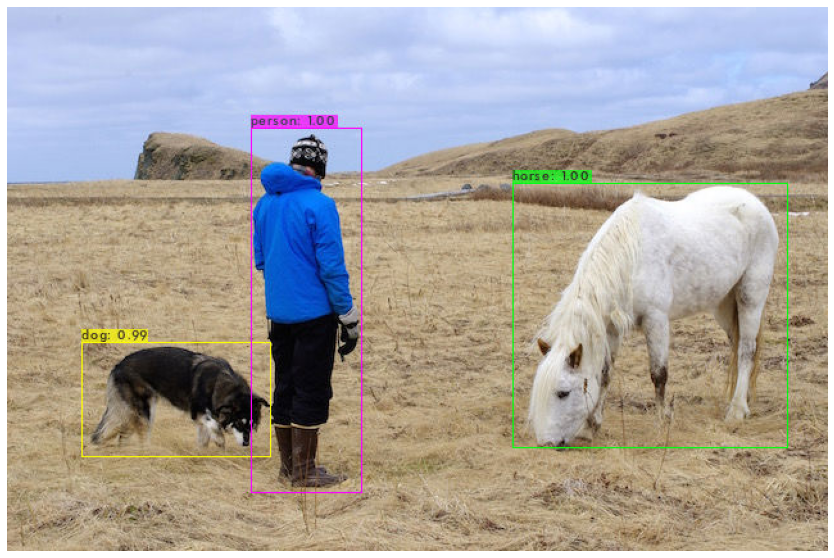

In [11]:
# Result image from yolov3 weights
imshow('predictions.jpg')

In [12]:
# Run darknet detection using yolov3-tiny weights
!./darknet detect cfg/yolov3-tiny.cfg /yolov3/yolov3-tiny.weights data/person.jpg

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 conv    256    

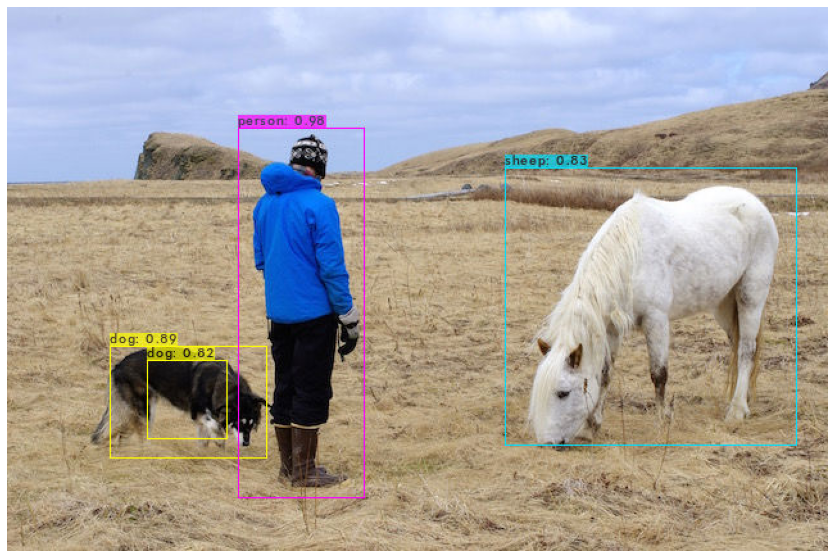

In [13]:
# Result image from yolov3-tiny weights
imshow('predictions.jpg')

## Download dataset from Google Cloud Storage

In [14]:
%cd /content/

/content


In [15]:
# Login to our GCP account
!gcloud auth login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=xTytraA2JdkenBkQbUh6IeN0xfOPx6&prompt=consent&access_type=offline&code_challenge=pLTbvxFpBLUUB4yJaTGxbSNN3TtFHtijaNInWuv2C5c&code_challenge_method=S256

Enter verification code: 4/1AY0e-g7SDoWle3otBnXNnQGnieSOHyoU9xEq9j4F0xI-A1p3Tq8iLBbJR6w

You are now logged in as [abuwildanm@gmail.com].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


To take a quick anonymous survey, run:
  $ gcloud survey



In [16]:
# Set project using our project ID
!gcloud config set project food-nutrition-312416

Updated property [core/project].


In [17]:
# Check the number of file in bucket
!gsutil ls -lR gs://food-nutrition/dataset | tail -n 1

TOTAL: 973 objects, 8041614 bytes (7.67 MiB)


In [18]:
# Download dataset from our bucket
# !mkdir ./dataset
!gsutil -m cp -r gs://food-nutrition/dataset .

Copying gs://food-nutrition/dataset/predefined-classes.txt...
Copying gs://food-nutrition/dataset/test/omelette/classes.txt...
Copying gs://food-nutrition/dataset/test/omelette/omelette-100.jpg...
Copying gs://food-nutrition/dataset/test/omelette/omelette-118.jpg...
Copying gs://food-nutrition/dataset/test/omelette/omelette-116.txt...
Copying gs://food-nutrition/dataset/test/omelette/omelette-100.txt...
Copying gs://food-nutrition/dataset/test/omelette/omelette-116.jpg...
Copying gs://food-nutrition/dataset/test/omelette/omelette-119.jpg...
Copying gs://food-nutrition/dataset/test/omelette/omelette-118.txt...
Copying gs://food-nutrition/dataset/test/omelette/omelette-119.txt...
Copying gs://food-nutrition/dataset/test/omelette/omelette-59.jpg...
Copying gs://food-nutrition/dataset/test/omelette/omelette-59.txt...
Copying gs://food-nutrition/dataset/test/omelette/omelette-74.jpg...
Copying gs://food-nutrition/dataset/test/omelette/omelette-74.txt...
Copying gs://food-nutrition/dataset/t

In [19]:
# Create symbolic link for yolov3 directory
!ln -s /content/models/yolov3 /yolov3

## View the dataset

In [20]:
%cd /content/

/content


In [21]:
import os
from glob import glob

with open('/content/dataset/predefined-classes.txt') as f:
    categories = f.read().splitlines()

print('Number of train images:')
for category in categories:
    print('{}: {}'.format(category, len(glob('dataset/train/{}/*.jpg'.format(category)))))

print('='*40)
print('Number of train annotation:')
for category in categories:
    # -1 because doesn't include classes.txt
    print('{}: {}'.format(category, len(glob('dataset/train/{}/*.txt'.format(category)))-1))

print('='*40)
print('Number of validation images:')
for category in categories:
    print('{}: {}'.format(category, len(glob('dataset/validation/{}/*.jpg'.format(category)))))

print('='*40)
print('Number of validation annotation:')
for category in categories:
    # -1 because doesn't include classes.txt
    print('{}: {}'.format(category, len(glob('dataset/validation/{}/*.txt'.format(category)))-1))

Number of train images:
omelette: 100
rice: 100
tempeh: 100
tofu: 100
Number of train annotation:
omelette: 100
rice: 100
tempeh: 100
tofu: 100
Number of validation images:
omelette: 10
rice: 10
tempeh: 10
tofu: 10
Number of validation annotation:
omelette: 10
rice: 10
tempeh: 10
tofu: 10


In [22]:
from cv2 import cv2
import matplotlib.pyplot as plt
import numpy as np

def show_bounding_boxes(image, annotation):
    dh, dw, _ = image.shape
    for label in annotation:
        # Split string to float
        _, x, y, w, h = map(float, label.split(' '))
                
        # Taken from https://github.com/pjreddie/darknet/blob/810d7f797bdb2f021dbe65d2524c2ff6b8ab5c8b/src/image.c#L283-L291
        # via https://stackoverflow.com/questions/44544471/how-to-get-the-coordinates-of-the-bounding-box-in-yolo-object-detection#comment102178409_44592380
        l = int((x - w / 2) * dw)
        r = int((x + w / 2) * dw)
        t = int((y - h / 2) * dh)
        b = int((y + h / 2) * dh)
                
        if l < 0: 
            l = 0
        if r > dw - 1: 
            r = dw - 1
        if t < 0:
            t = 0
        if b > dh - 1:
            b = dh - 1

        cv2.rectangle(image, (l, t), (r, b), (255, 0, 0), 2)

def show_images(category, data_type='train', size=10, show_bbox=False):
    # Path of all image in category directory
    img_path = glob('dataset/{}/{}/*.jpg'.format(data_type, category))
    # Path to category directory
    annotation_dir = 'dataset/{}/{}'.format(data_type, category)
    # Shuffle the path
    np.random.shuffle(img_path)
    
    # Adjust rows & cols for subplotting
    nrows = 2
    ncols = size / nrows
    # Create figure for plot the image
    fig = plt.figure(figsize=(15, 6))
    # Plot process
    for idx in range(size):
        # Create subplot
        ax = fig.add_subplot(nrows, ncols, idx+1, xticks=[], yticks=[])
        # Read the image
        image = plt.imread(img_path[idx])
        # Open the annotation
        image_name = os.path.basename(img_path[idx]).split('.')[0]
        annotation_path = '{}/{}.txt'.format(annotation_dir, image_name)
        f = open(annotation_path, 'r')
        annotation = f.read().splitlines()
        f.close()

        if show_bbox: show_bounding_boxes(image, annotation)
        
        # Plot the image
        plt.title(os.path.basename(img_path[idx]))
        plt.imshow(image)

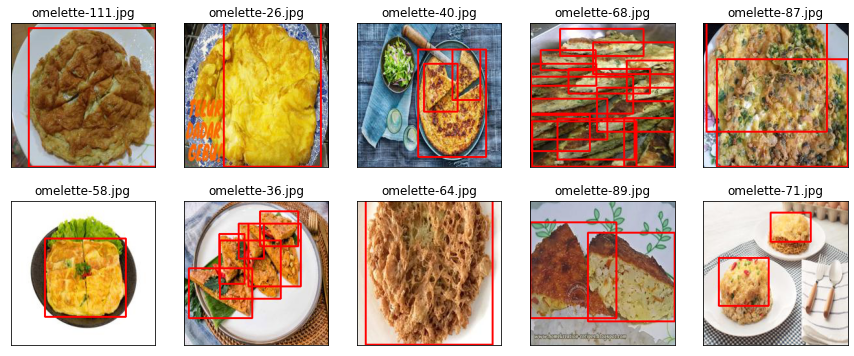

In [23]:
show_images('omelette', show_bbox=True)

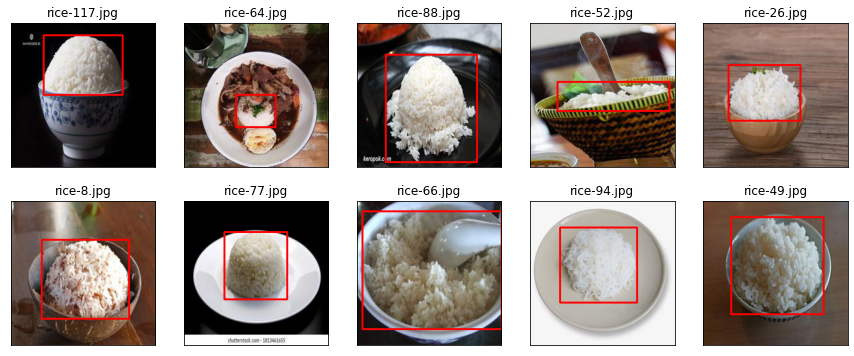

In [24]:
show_images('rice', show_bbox=True)

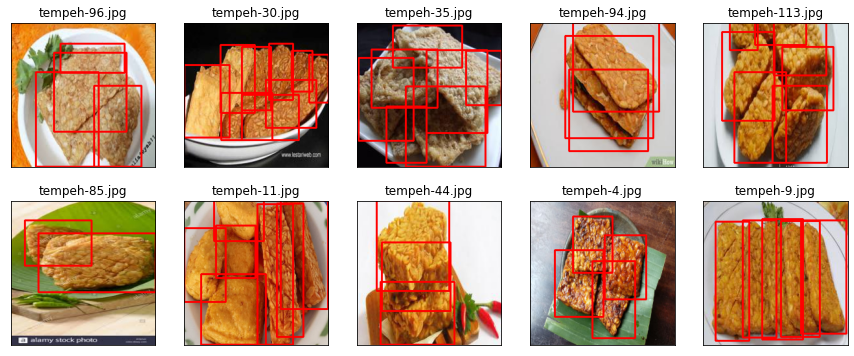

In [25]:
show_images('tempeh', show_bbox=True)

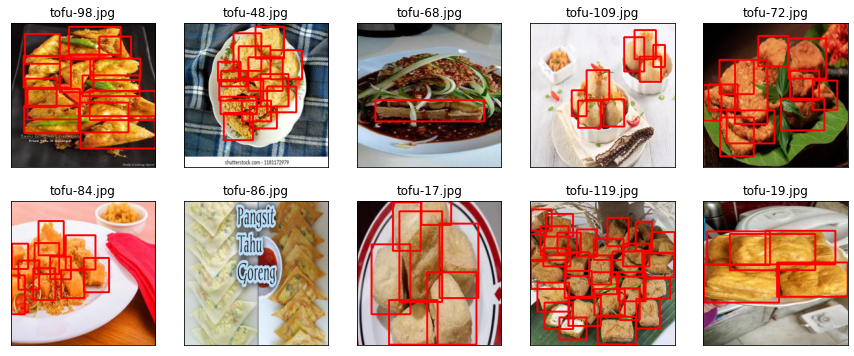

In [26]:
show_images('tofu', show_bbox=True)

## Configuring Files for Training

This step involves properly configuring our custom .cfg file, train.data, train.names and train.txt file. For more complete guidance, we can follow: [How to train (to detect your custom objects)](https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects)

### Configuration for YOLOv3

In [27]:
%cd /content/

/content


In [28]:
# Comment this command if we have configured our config
!cp darknet/cfg/yolov3.cfg /yolov3/yolov3-custom.cfg
!cp darknet/cfg/yolov3-tiny.cfg /yolov3/yolov3-tiny-custom.cfg

Now we need to edit the .cfg file to fit our needs based on our object detector. Open it up in a code or text editor to do so.

If we downloaded cfg to google drive, we can use the built in  **Text Editor** by going to our google drive and double clicking on yolov3_custom.cfg and then clicking on the **Open with** drop down and select in **Text Editor**.

I edit the .cfg file with this configuration

```
[net]
# Testing
# batch=1
# subdivisions=1
# Training
batch=64
subdivisions=16

max_batches = 8000
steps=6400,7200

[convolutional]
filters=27

[yolo]
classes=4
```

I recommend having **batch = 64** and **subdivisions = 16** for ultimate results. If we run into any issues then up subdivisions to 32.

Make the rest of the changes to the cfg based on how many classes we are training on our detector.

**Note:** I set my **max_batches = 8000** (max_batches = (classes * 2000)), **steps = 6400, 7200** (steps = 80%, 90% max_batches), I changed the **classes = 4** in the three YOLO layers and **filters = 27** (filters = (classes + 5)x3) in the three convolutional layers before the YOLO layers. 

**Optional:** In each of the three yolo layers in the cfg, change one line from random = 1 to **random = 0** to speed up training but slightly reduce accuracy of model. Will also help save memory if we run into any memory issues.

In [29]:
!cat /yolov3/yolov3-custom.cfg

[net]
# Testing
batch=1
subdivisions=1
# Training
# batch=64
# subdivisions=16
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 500200
policy=steps
steps=400000,450000
scales=.1,.1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

# Downsample

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

# Downsample

[convolutional]
batch_normalize=1
filters=128
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutiona

In [30]:
# Search filters in the 3 [convolutional] before each [yolo] layer
!cat /yolov3/yolov3-custom.cfg | grep 'filters=255'

filters=255
filters=255
filters=255


In [31]:
# Configuration for YOLOv3
# Comment the batch & subdivisions for testing
!sed -i '3 s/batch=1/# batch=1/' /yolov3/yolov3-custom.cfg
!sed -i '4 s/subdivisions=1/# subdivisions=1/' /yolov3/yolov3-custom.cfg
# Uncomment the batch & subdivisions for training
!sed -i '6 s/# batch=64/batch=64/' /yolov3/yolov3-custom.cfg
!sed -i '7 s/# subdivisions=16/subdivisions=16/' /yolov3/yolov3-custom.cfg
# Change the value of max_batches
!sed -i 's/max_batches = 500200/max_batches=8000/' /yolov3/yolov3-custom.cfg
# Change the value of steps
!sed -i 's/steps=400000,450000/steps=6400,7200/' /yolov3/yolov3-custom.cfg
# Change the value of filters in the 3 [convolutional] before each [yolo] layer
!sed -i 's/filters=255/filters=27/' /yolov3/yolov3-custom.cfg
# Change the value of classes
!sed -i 's/classes=80/classes=4/' /yolov3/yolov3-custom.cfg

In [32]:
!cat /yolov3/yolov3-custom.cfg

[net]
# Testing
# batch=1
# subdivisions=1
# Training
batch=64
subdivisions=16
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches=8000
policy=steps
steps=6400,7200
scales=.1,.1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

# Downsample

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

# Downsample

[convolutional]
batch_normalize=1
filters=128
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]
batch

### Configuration for Tiny-YOLOv3

In [33]:
!cat /yolov3/yolov3-tiny-custom.cfg

[net]
# Testing
batch=1
subdivisions=1
# Training
# batch=64
# subdivisions=2
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 500200
policy=steps
steps=400000,450000
scales=.1,.1

[convolutional]
batch_normalize=1
filters=16
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=1

[convolutional]
batch_normalize=1
filter

In [34]:
# Search filters in the 3 [convolutional] before each [yolo] layer
!cat /yolov3/yolov3-tiny-custom.cfg | grep 'filters=255'

filters=255
filters=255


In [35]:
# Configuration for Tiny-YOLOv3
# Comment the batch & subdivisions for testing
!sed -i '3 s/batch=1/# batch=1/' /yolov3/yolov3-tiny-custom.cfg
!sed -i '4 s/subdivisions=1/# subdivisions=1/' /yolov3/yolov3-tiny-custom.cfg
# Uncomment the batch & subdivisions for training
!sed -i '6 s/# batch=64/batch=64/' /yolov3/yolov3-tiny-custom.cfg
!sed -i '7 s/# subdivisions=2/subdivisions=2/' /yolov3/yolov3-tiny-custom.cfg
# Change the value of max_batches
!sed -i 's/max_batches = 500200/max_batches=8000/' /yolov3/yolov3-tiny-custom.cfg
# Change the value of steps
!sed -i 's/steps=400000,450000/steps=6400,7200/' /yolov3/yolov3-tiny-custom.cfg
# Change the value of filters in the 3 [convolutional] before each [yolo] layer
!sed -i 's/filters=255/filters=27/' /yolov3/yolov3-tiny-custom.cfg
# Change the value of classes
!sed -i 's/classes=80/classes=4/' /yolov3/yolov3-tiny-custom.cfg

In [36]:
!cat /yolov3/yolov3-tiny-custom.cfg

[net]
# Testing
# batch=1
# subdivisions=1
# Training
batch=64
subdivisions=2
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches=8000
policy=steps
steps=6400,7200
scales=.1,.1

[convolutional]
batch_normalize=1
filters=16
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=1

[convolutional]
batch_normalize=1
filters=1024
s

### Create food.names & food.data file
Create a new file within a code or text editor called **food.names** and fill it with this configuration
```
omelette
rice
tempeh
tofu
```

We will also create a **food.data** file and fill it with this configuration
```
classes = 4
train = /yolov3/train.txt
valid = /yolov3/valid.txt
names = /yolov3/train.names
backup = /yolov3/backup/
```

The backup path is where we will save the weights of our model throughout training. Create a backup folder in our google drive and put its correct path in this file.

**Note:** The name of file .names and .data must same with the directory that we use for save training data + training labels. In here we use **train directory** which contains training data/images and training labels (.txt)

In [37]:
# Create food.names file from predefined-classes.txt file
!cp dataset/predefined-classes.txt /yolov3/food.names

In [38]:
# Create train.txt & valid.txt to save train & validation image path
!touch /yolov3/train.txt
!touch /yolov3/valid.txt

# Create backup directory to save model weights while training
!mkdir -p /yolov3/backup/

In [39]:
train_data = glob('/content/dataset/train/*/*.jpg')
valid_data = glob('/content/dataset/validation/*/*.jpg')

with open('/yolov3/train.txt', 'w+') as f:
    for item in train_data:
        f.write('{}\n'.format(item))

with open('/yolov3/valid.txt', 'w+') as f:
    for item in valid_data:
        f.write('{}\n'.format(item))

In [40]:
!head -5 /yolov3/train.txt

/content/dataset/train/rice/rice-46.jpg
/content/dataset/train/rice/rice-89.jpg
/content/dataset/train/rice/rice-68.jpg
/content/dataset/train/rice/rice-95.jpg
/content/dataset/train/rice/rice-5.jpg


In [41]:
!head -5 /yolov3/valid.txt

/content/dataset/validation/rice/rice-50.jpg
/content/dataset/validation/rice/rice-44.jpg
/content/dataset/validation/rice/rice-20.jpg
/content/dataset/validation/rice/rice-39.jpg
/content/dataset/validation/rice/rice-28.jpg


In [42]:
!wc -l /yolov3/train.txt /yolov3/valid.txt

  400 /yolov3/train.txt
   40 /yolov3/valid.txt
  440 total


In [43]:
print('Total train data:', len(train_data))
print('Total validation data:', len(valid_data))

Total train data: 400
Total validation data: 40


In [44]:
# Create food.data file

%%shell
cat > /yolov3/food.data << EOF
classes = 4
train = /yolov3/train.txt
valid = /yolov3/valid.txt
names = /yolov3/train.names
backup = /yolov3/backup/
EOF

In [45]:
!cat /yolov3/food.names

omelette
rice
tempeh
tofu

In [46]:
!cat /yolov3/food.data

classes = 4
train = /yolov3/train.txt
valid = /yolov3/valid.txt
names = /yolov3/train.names
backup = /yolov3/backup/


In [47]:
!ls /yolov3/

backup	   food.names  valid.txt  yolov3-custom.cfg	  yolov3-tiny.weights
food.data  train.txt   yolov3	  yolov3-tiny-custom.cfg  yolov3.weights


## Download pre-trained weights for the convolutional layers

This step downloads the weights for the convolutional layers of the YOLOv3 network. By using these weights it helps our custom object detector to be way more accurate and not have to train as long. We actually can not use these weights, but if we use it, it will help our model converge and be accurate way faster. USE IT!

In [48]:
# Download pretrained convolutional layer weights for yolov3
!wget http://pjreddie.com/media/files/darknet53.conv.74
!cp darknet53.conv.74 /yolov3/

# Download pretrained convolutional layer weights for yolov3-tiny
!gdown --id 18v36esoXCh-PsOKwyP2GWrpYDptDY8Zf
!cp yolov3-tiny.conv.11 /yolov3/

URL transformed to HTTPS due to an HSTS policy
--2021-05-21 21:55:13--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  45.1MB/s    in 3.8s    

2021-05-21 21:55:17 (41.0 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]

Downloading...
From: https://drive.google.com/uc?id=18v36esoXCh-PsOKwyP2GWrpYDptDY8Zf
To: /content/yolov3-tiny.conv.11
6.30MB [00:00, 55.4MB/s]


## Upload the temporary model to Google Cloud Storage

In [49]:
# Upload temporary models to our bucket
!gsutil -m cp -r ./models gs://food-nutrition/

Skipping symlink directory "./models/yolov3/yolov3"
Copying file://./models/yolov3/yolov3-tiny.conv.11 [Content-Type=application/octet-stream]...
Copying file://./models/yolov3/train.txt [Content-Type=text/plain]...
Copying file://./models/yolov3/food.names [Content-Type=application/octet-stream]...
Copying file://./models/yolov3/valid.txt [Content-Type=text/plain]...
Copying file://./models/yolov3/darknet53.conv.74 [Content-Type=application/octet-stream]...
Copying file://./models/yolov3/yolov3.weights [Content-Type=application/octet-stream]...
Copying file://./models/yolov3/yolov3-tiny.weights [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud

## Train Our Custom Object Detector
The time has finally come! We have made it to the moment of truth! We are now ready to train our custom YOLOv3 object detector on whatever crazy classes we have decided on. So run the following command. (dont_show flag stops a chart from popping up since cloud can't open images on the spot)
```
!./darknet detector train <path to obj.data> <path to custom config> darknet53.conv.74 -dont_show
```
**TIP:** This training could take several hours depending on how many iterations we chose in the .cfg file. We will want to let this run as we sleep or go to work for the day, etc. However, Colab Cloud Service kicks us off it's VMs if we are idle for too long (30-90 mins).

To avoid this hold (CTRL + SHIFT + i) at the same time to open up the inspector view on your browser.

Paste the following code into your console window and hit **Enter**
```
function ClickConnect(){
    console.log("Working"); 
    document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)
```
Looks like this, it will click the screen every 10 minutes so that we don't get kicked off for being idle! HACKS!

In [50]:
%cd darknet

/content/darknet


In [ ]:
# Train our custom detector
!./darknet detector train /yolov3/food.data /yolov3/yolov3-custom.cfg /yolov3/darknet53.conv.74 -dont_show -map

Streaming output truncated to the last 5000 lines.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.731131), count: 4, class_loss = 0.295320, iou_loss = 0.268497, total_loss = 0.563816 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.000023, iou_loss = 0.000000, total_loss = 0.000023 
 total_bbox = 557624, rewritten_bbox = 0.305224 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.844108), count: 9, class_loss = 0.768589, iou_loss = 0.158928, total_loss = 0.927518 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.786148), count: 7, class_loss = 0.503395, iou_loss = 0.505101, total_loss = 1.008496 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.501841), count: 2, class_loss = 0.546937, iou_loss = 0.528431, total_loss = 1.075368 
 total_bbox = 557642, rewritten_bbox = 0.305214 % 
v3 (m

In [ ]:
imshow('chart.png')

**TRICK**: If for some reason we get an error or our Colab goes idle during training, we have not lost our weights! Every 100 iterations a weights file called **yolov3-custom_last.weights** is saved to **/yolov3/backup/** folder (wherever our backup folder is). This is why we created this folder in our Google drive and not on the cloud VM. If our runtime crashes and our backup folder was in our cloud VM we would lose our weights and our training progress.

We can kick off training from our last saved weights file so that we don't have to restart! WOOHOO! Just run the following command but with our backup location.
```
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg /mydrive/yolov3/backup/yolov3_custom_last.weights -dont_show
```

In [ ]:
# !./darknet detector train /yolov3/train.data /yolov3/yolov3-custom.cfg /yolov3/backup/yolov3-custom_last.weights -dont_show

## Run Our Custom Object Detector
We have done it! We now have a custom object detector to make our very own detections. Time to test it out and have some fun!

In [ ]:
!cp /yolov3/yolov3-custom.cfg /yolov3/yolov3-custom-test.cfg

In [ ]:
# Configuration for YOLOv3 testing
# Comment the batch & subdivisions for testing
!sed -i '3 s/# batch=1/batch=1/' /yolov3/yolov3-custom-test.cfg
!sed -i '4 s/# subdivisions=1/subdivisions=1/' /yolov3/yolov3-custom-test.cfg
# Uncomment the batch & subdivisions for training
!sed -i '6 s/batch=64/# batch=64/' /yolov3/yolov3-custom-test.cfg
!sed -i '7 s/subdivisions=16/# subdivisions=16/' /yolov3/yolov3-custom-test.cfg